# Exploratie van de inschrijvingen

In [2]:
%matplotlib notebook

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas

from shapely.geometry import Point

**Data inlezen**

In [6]:
data = pd.read_csv("RAWdata-08-04.csv", names=["wp_form_id","post_id","latitude","longitude","voornaam","naam","email","tel","straat","nummer","bus","postcode","plaats","gebouw_type","in_meetgebied","raam_straat","v_bord","verdiep_1","verdiep_ander","nieuwsbrief"])

In [8]:
data['geometry'] = data.apply(lambda x: Point(x['longitude'], x['latitude']), axis=1)

In [9]:
data = geopandas.GeoDataFrame(data)

Coordinaten referentiesysteem naar UTM:

In [10]:
data.crs = {'init': 'epsg:4326', 'no_defs': True}

In [11]:
data = data.to_crs(epsg=31370)

OpenStreetMap straten:

In [12]:
streets = geopandas.read_file("layer_openstreetmap_streets.shp")

## Meetlocaties op een kaart

<IPython.core.display.Javascript object>


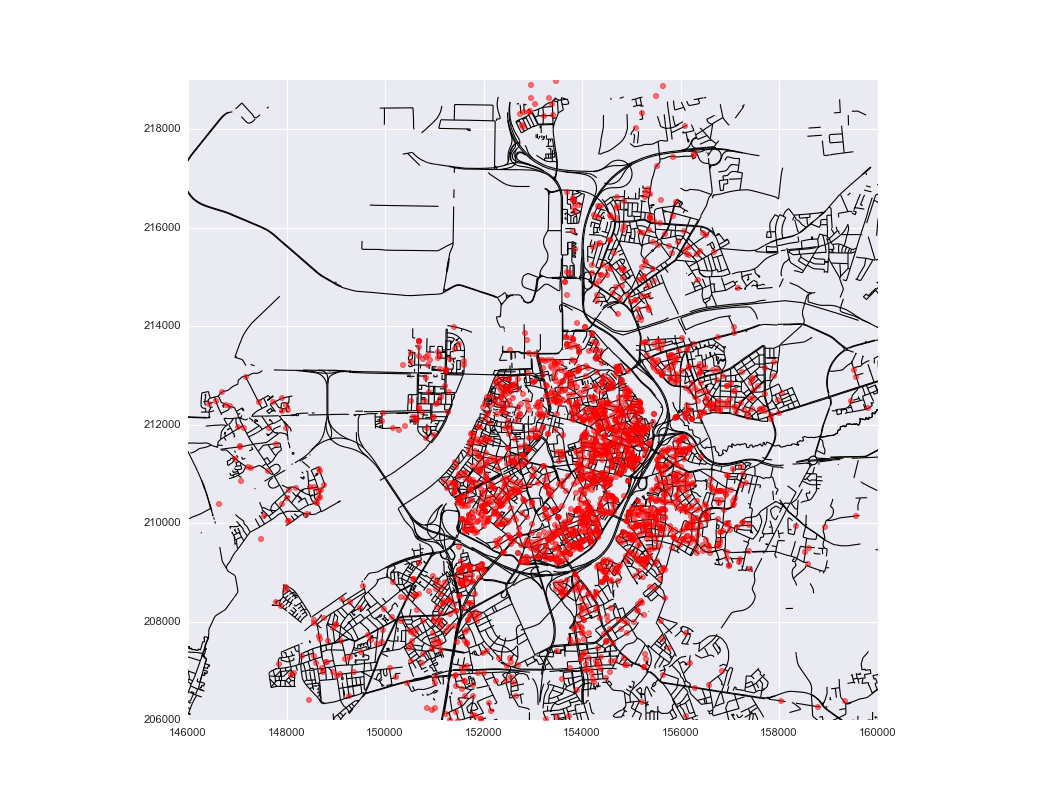

[(146000, 160000), (206000, 219000)]

In [13]:
ax = streets.plot(color='k', figsize=(13,10))
data.plot(ax=ax, color='r', zorder=10, alpha=0.5)
ax.set(xlim=(146000, 160000), ylim=(206000, 219000))

Er zijn een aantal locaties die zeer ver van Antwerpen liggen:

<IPython.core.display.Javascript object>


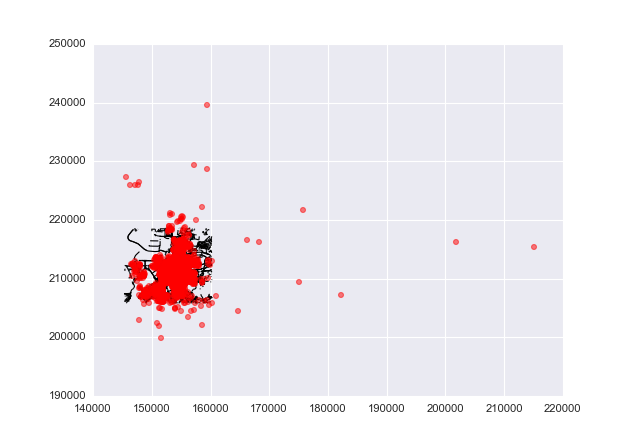

In [14]:
ax = streets.plot(color='k')
data.plot(ax=ax, color='r', zorder=10, alpha=0.5)

## Type gebouwen?

<IPython.core.display.Javascript object>


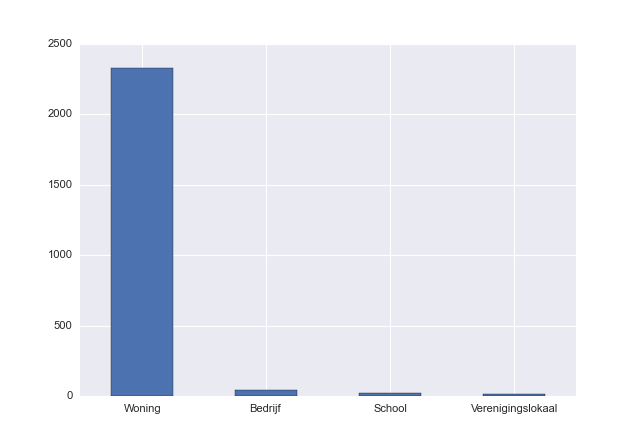

In [15]:
fig, ax = plt.subplots()
data['gebouw_type'].dropna().value_counts().plot(kind='bar', ax=ax, rot=0)

## Op de eerste verdieping of niet?

<IPython.core.display.Javascript object>


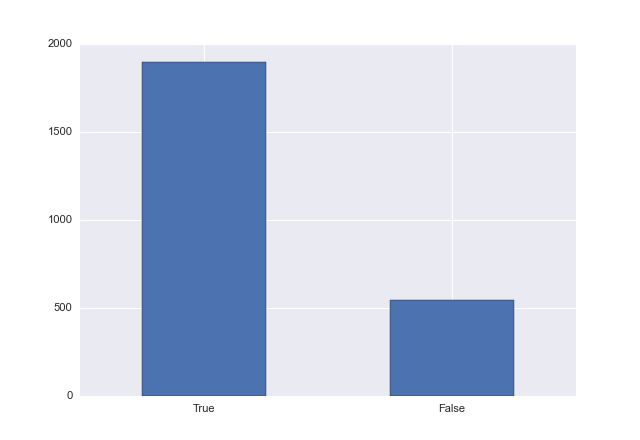

In [16]:
plt.figure()
data['verdiep_1'].value_counts().plot(kind='bar', rot=0)

## En indien niet, welke verdieping dan wel?

In [20]:
m = {'gelijkvloers': ['gelijkvloers'],
     '2de': ['2', 'tweede verdieping', '2e verdieping', '2de verdieping', '2e', 'tweede', '2de verdiep', 'op de tweede verdieping'],
     '3de': ['3', 'derde verdieping', 'derde', '3e', '3de verdieping', 'op de 3de verdieping', '3de ved.', '3e verdieping'],
     '4de': ['4', '4de verdieping', '4e', 'vierde', 'vierde verdieping'],
     '5de': ['5', 'verdieping 5', '5e verdieping', '5de verdieping'],
     '6de': ['6', '6de verdieping', '6e verdieping', '6 de'],
     '7de': ['7', '7de verdieping'],
     '8ste': ['8', '8ste verdieping']}

m = {'gelijkvloers': ['gelijkvloers', 'gelijkvloerse verdieping', 'gelijkvloerse', 'glvl', 'gelijksvloer', 'glv'],
     '2de': ['2', 'tweede', 'tweede verdieping', '2de verdieping', '2e', '2de verdiep', '2e verdieping', '2e verdiep', 'twee', '2 verdieping appartement', 'op de tweede verdieping'],
     '3de': ['3', 'derde', 'derde verdieping', '3de verdieping', '3e', '3de ved.', 'De derde', '3e verdieping', '3rde', '3° VERDIEPING', 'op de 3de verdieping', '3e verdiep'],
     '4de': ['4', 'vierde', 'vierde verdieping', '4de verdieping', '4e', '4e verdieping'],
     '5de': ['5', 'vijfde', 'vijfde verdieping', '5de verdieping', '5e', '5 de', 'verdieping 5', '5e verdieping'],
     '6de': ['6', 'zesde', 'zesde verdieping', '6de verdieping', '6e', '6e verdieping', '6 de', '6de verdiep'],
     '7de': ['7', 'zevende', 'zevende verdieping', '7de verdieping', '7e', '7 de', '7 de verdieping', '7de verdiep'],
     '8ste': ['8', 'achtste', 'achtste verdieping', '8ste verdieping', '8e', '8ste verdieping'],
     '>8': ['9', '10', '11', '12', '13', '14', '15', '11de verdieping', '11e', '11de', '12de verdieping', '12e', '12de', '12e verdieping', '12 de verdieping', '13e verdieping', '13e', '13de', '14e verdieping', '14e', '14de', '14 de', '15e verdieping', '15e', '15de', '18e verdieping', '18e', '18de', '18de verdieping'] }

m2 = {val: key for key in m for val in m[key]}

In [21]:
verdiep = data['verdiep_ander'].dropna().astype(str).str.lower()

<IPython.core.display.Javascript object>


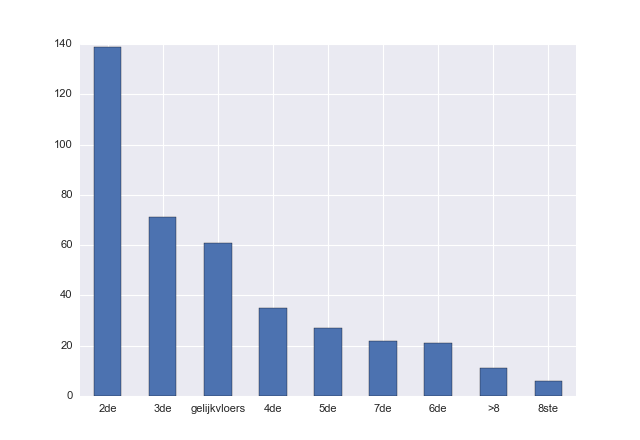

In [23]:
plt.figure()
verdiep.replace(m2).value_counts().head(9).plot(kind='bar', rot=0)

## In welk type straat liggen de meetlocaties?

Dit gebruikt de types zoals ze in OpenStreetMap zitten, onderaan staat ook een kaartje waarop is aangeduid welke straat welk type is (probleem is wel dat de kaart van OpenStreetMap niet helemaal volledig is).

In [16]:
def closest_road(point, streets):
    """Distance to the nearest road [m] (OpenStreetMap)"""
    dist = streets.distance(point)
    return pd.Series([dist.min(), dist.idxmin()], index=['d_closest', 'closest'])

In [17]:
data[['d_closest', 'closest']] = data.geometry.apply(lambda x: closest_road(x, streets))

In [18]:
data['closest_type'] = data['closest'].replace(streets['highway'])

<IPython.core.display.Javascript object>


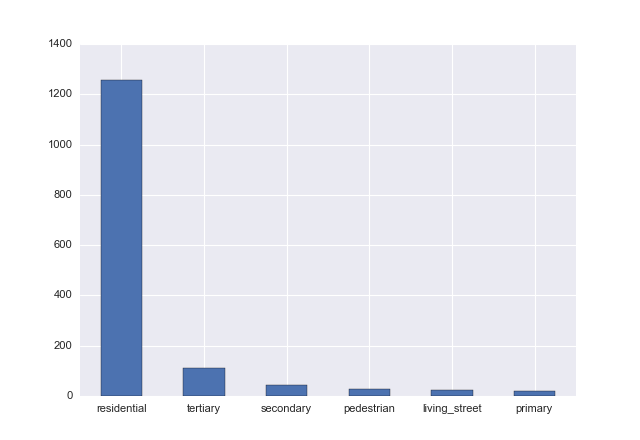

In [19]:
plt.figure()
data['closest_type'][data['d_closest'] < 15].value_counts().plot(kind='bar', rot=0)

<IPython.core.display.Javascript object>


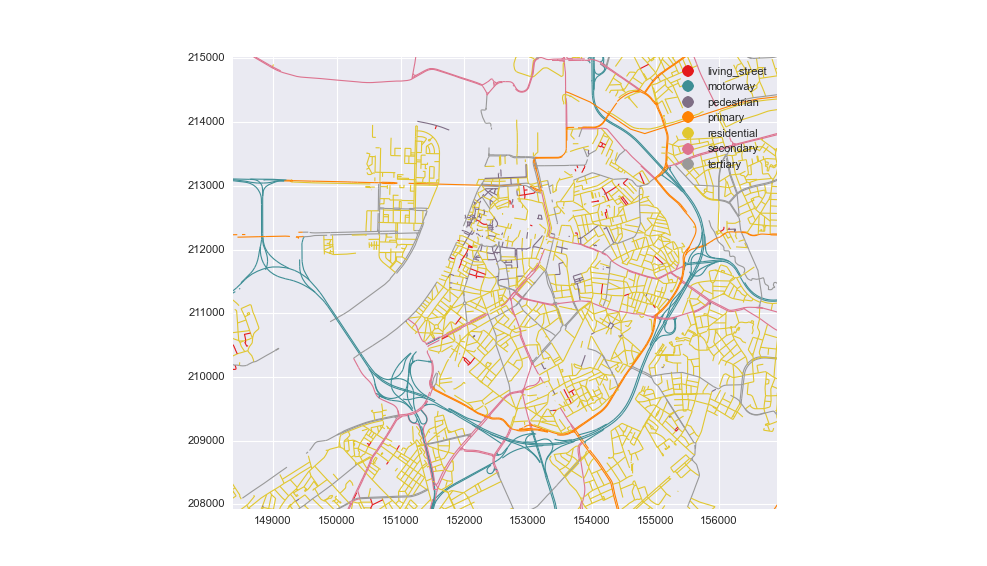

In [195]:
streets.plot(column='highway', legend=True, cmap='Set1', alpha=1)

## Verkeersintensiteit?

In [24]:
traffic = geopandas.read_file("layer_trafficantwerp.shp")

<IPython.core.display.Javascript object>


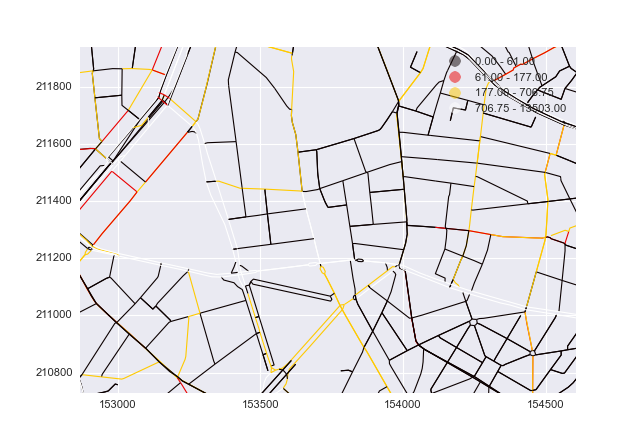

In [30]:
traffic.plot(column='Q_TOTAL', legend=True, scheme='quantiles', k=8, cmap='hot')

In [33]:
def trafnear(point, traffic):
    """
    Traffic intensity on the nearest road [Veh day$^{-1}$]

    """
    closest_street = traffic.loc[traffic.distance(point).idxmin()].geometry
    closest_point = closest_street.interpolate(closest_street.project(point))
    closest_streets = traffic[traffic.geometry.intersects(closest_point.buffer(20))]
    return closest_streets['Q_TOTAL'].max()

In [34]:
data['trafnear'] = data.geometry.apply(lambda x: trafnear(x, traffic))

<IPython.core.display.Javascript object>


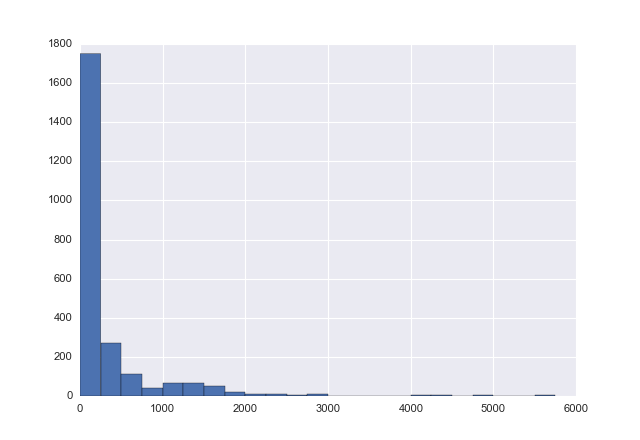

In [38]:
plt.figure()
data['trafnear'].hist(bins=np.arange(0, 6000, 250))

<IPython.core.display.Javascript object>


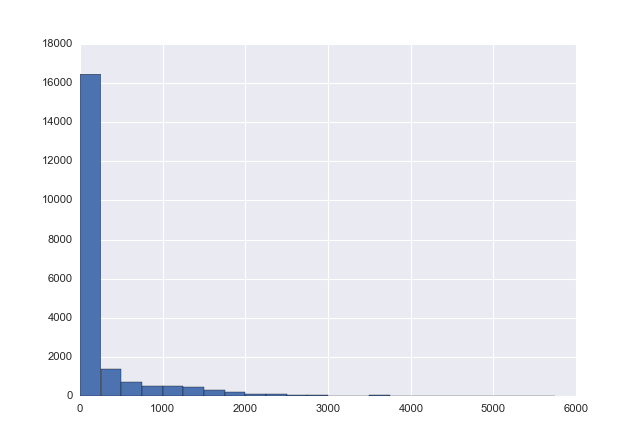

In [41]:
plt.figure()
traffic['Q_TOTAL'].hist(bins=np.arange(0, 6000, 250))

In [44]:
data[['wp_form_id', 'post_id', 'geometry', 'trafnear']].to_file("data.shp")